In [38]:
## Link to repository - https://github.com/biony1209/DSCI-510-Final-Project

## Data Collection and Preparation

In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [392]:
covid = pd.read_csv(r'C:\Users\jaimv\Downloads\covid.csv')
noncovid = pd.read_csv(r'C:\Users\jaimv\Downloads\noncovid.csv')

In [393]:
#df = pd.read_csv('../data/covidsample.csv')

In [394]:
covid.rename({'date_died': 'outcome'}, axis=1, inplace=True)

In [395]:
noncovid = noncovid[["ID", "outcome", "age", "gendera", "hypertensive", "diabetes"]]

In [396]:
noncovid.rename({'ID': 'id', 'gendera': 'sex', 'hypertensive': 'hypertension'}, axis=1, inplace=True)

In [397]:
transform={2:1,1:0}
covid = covid.replace({'sex':transform,'hypertension':transform, 'diabetes':transform})

In [398]:
noncovid = noncovid.replace({'sex':transform})

In [399]:
covid['outcome'][covid['outcome']!='9999-99-99']=1.0

In [400]:
covid['outcome'][covid['outcome']!=1]=0.0

In [401]:
covid = covid[["id", "outcome", "age", "sex", "hypertension", "diabetes"]]

In [402]:
covid['covid_status'] = 1
noncovid['covid_status'] = 0

In [403]:
covid['outcome'] = covid['outcome'].dropna().astype('uint8')

In [404]:
covid

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
566597,01ff60,0,58,1,1,0,1
566598,047cd1,0,48,0,1,1,1
566599,1beb81,0,49,0,1,1,1
566600,16fb02,0,43,0,1,1,1


In [405]:
covid = covid[covid['outcome'] != 98]
covid = covid[covid['sex'] != 98]
covid = covid[covid['hypertension'] != 98]
covid = covid[covid['diabetes'] != 98]

In [406]:
noncovid = noncovid.dropna()
covid = covid.dropna()

In [407]:
noncovid['outcome'] = noncovid['outcome'].astype(int)
covid['outcome'] = covid['outcome'].astype(int)

In [408]:
noncovid

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,125047,0,72,0,0,1,0
1,139812,0,75,1,0,0,0
2,109787,0,83,1,0,0,0
3,130587,0,43,1,0,0,0
4,138290,0,75,1,1,0,0
...,...,...,...,...,...,...,...
1172,171130,0,62,0,1,1,0
1173,101659,0,78,0,0,1,0
1174,162069,0,85,1,1,1,0
1175,120967,0,79,1,0,1,0


## Odds Ratio Analysis

In [409]:
full_cohort = [covid, noncovid]

result = pd.concat(full_cohort, ignore_index=True)

In [410]:
result = result[~result['outcome'].isnull()]
result['outcome'] = result['outcome'].astype(int)
result['age'] = result['age'].astype(int)
result['sex'] = result['sex'].astype(int)
result['hypertension'] = result['hypertension'].astype(int)
result['diabetes'] = result['diabetes'].astype(int)
result['covid_status'] = result['covid_status'].astype(int)

In [411]:
import statsmodels.formula.api as smf

In [412]:
model=smf.logit(formula='outcome ~ covid_status + age + sex',data=result).fit()
model_odds=pd.DataFrame(np.exp(model.params),columns=['Odds Ratio'])
model_odds['p-value']=model.pvalues
model_odds[['5%','95%']]=np.exp(model.conf_int())
model_odds['significant']=model_odds['p-value']<.05
model_odds=model_odds.drop('Intercept')
model_odds=model_odds.sort_values(by='Odds Ratio',ascending=False)
model_odds

Optimization terminated successfully.
         Current function value: 0.195904
         Iterations 8


,Odds Ratio,p-value,5%,95%,significant
covid_status,2.841336,8.996275e-32,2.386385,3.383022,True
sex,1.807317,0.000000e+00,1.765253,1.850383,True
age,1.071549,0.000000e+00,1.070798,1.072301,True


## Matching Preparation

In [413]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [414]:
covid_sample = covid.head(30000)
noncovid_sample = noncovid.head(200)

In [415]:
covid_sample

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
30123,0d9b71,0,69,0,1,1,1
30124,0032c6,0,33,0,1,1,1
30125,0cb27f,0,21,0,1,1,1
30126,15200b,0,52,1,1,1,1


In [416]:
full_sample_cohort = [covid_sample, noncovid_sample]

result = pd.concat(full_sample_cohort, ignore_index=True)

In [417]:
result

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
30195,169909,0,58,1,0,0,0
30196,159724,1,89,0,1,0,0
30197,133975,0,71,0,1,0,0
30198,114524,0,63,1,0,0,0


In [418]:
result = result[["age", "sex", "hypertension", "diabetes", "covid_status"]]

In [419]:
X=result.drop(['covid_status'],axis='columns')
lr = LogisticRegression()
lr.fit(X,result['covid_status'])

LogisticRegression()

In [420]:
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
pred_prob = lr.predict_proba(X)
result['ps'] = pred_prob[:, 1]

def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

result['ps_logit'] = result['ps'].apply(lambda x: logit(x))

## Before Matching

In [421]:
result1 = result[result['covid_status'] == 0]
result2 = result[result['covid_status'] == 1]

[Text(0.5, 1.0, 'COVID Negative Probability Distribution')]

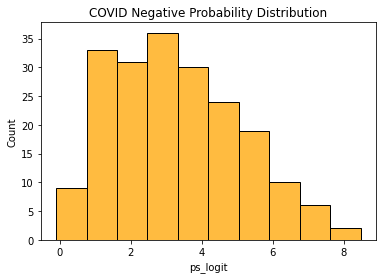

In [422]:
sns.histplot(data=result1, x='ps_logit', color = 'orange').set(title = "COVID Negative Probability Distribution")

[Text(0.5, 1.0, 'COVID Positive Probability Distribution')]

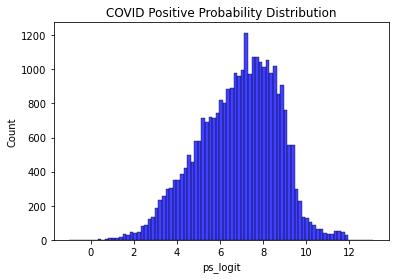

In [423]:
sns.histplot(data=result2, x='ps_logit', color="blue").set(title = "COVID Positive Probability Distribution")

## Matching

In [424]:
exclude=[]
def perfom_matching(row, indexes, df_data):
    current_index = row.name
    prop_score_logit = row['ps_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row['covid_status'] == 0) and (df_data.loc[idx]['covid_status'] == 1) and (idx not in exclude):
            exclude.append(idx)
            return int(idx)

def obtain_match_details(row, all_data, attribute, key):
    return all_data.loc[row[key]][attribute]

In [425]:
caliper=np.std(result['ps'])*.25
print(f'caliper (radius) is: {caliper:.4f}')

knn = NearestNeighbors(n_neighbors=200,algorithm='ball_tree',radius=caliper)
knn.fit(result[['ps_logit']])
distances, indexes = knn.kneighbors(result[['ps_logit']])

caliper (radius) is: 0.0056


In [426]:
result = result.reset_index()
del result['index']

In [427]:
result['matched_1']=result.reset_index().apply(perfom_matching,axis='columns',args=(indexes, result))

covid_hosp_match=result[~result['matched_1'].isna()][result.columns]
control_hosp_match_1=pd.DataFrame(data=covid_hosp_match['matched_1'])

for attr in result.drop('matched_1',axis='columns'):
    control_hosp_match_1[attr]=control_hosp_match_1.apply(obtain_match_details,axis='columns',all_data=result,attribute=attr,key='matched_1')
    
control_hosp_match_1=control_hosp_match_1.set_index('matched_1')

In [428]:
result['matched_2']=result.reset_index().apply(perfom_matching,axis='columns',args=(indexes, result))

covid_hosp_match=result[~result['matched_2'].isna()][result.columns]
control_hosp_match_2=pd.DataFrame(data=covid_hosp_match['matched_2'])

for attr in result.drop(['matched_1','matched_2'],axis='columns'):
    control_hosp_match_2[attr]=control_hosp_match_2.apply(obtain_match_details,axis='columns',all_data=result,attribute=attr,key='matched_2')
    
control_hosp_match_2=control_hosp_match_2.set_index('matched_2')

In [429]:
result['matched_3']=result.reset_index().apply(perfom_matching,axis='columns',args=(indexes, result))

covid_hosp_match=result[~result['matched_3'].isna()][result.columns]
control_hosp_match_3=pd.DataFrame(data=covid_hosp_match['matched_3'])

for attr in result.drop(['matched_1','matched_2','matched_3'],axis='columns'):
    control_hosp_match_3[attr]=control_hosp_match_3.apply(obtain_match_details,axis='columns',all_data=result,attribute=attr,key='matched_3')
    
control_hosp_match_3=control_hosp_match_3.set_index('matched_3')

In [430]:
all_matched_result=pd.concat([result[result['covid_status']==0],control_hosp_match_1,control_hosp_match_2,control_hosp_match_3],ignore_index=True)

## After Matching

In [431]:
matchedresult1 = all_matched_result[all_matched_result['covid_status'] == 0]
matchedresult2 = all_matched_result[all_matched_result['covid_status'] == 1]

[Text(0.5, 1.0, 'Matched COVID Negative Probability Distribution')]

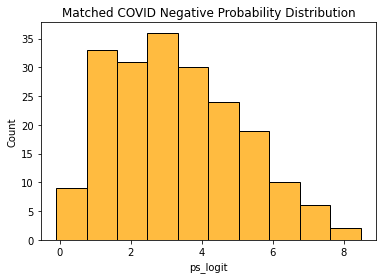

In [432]:
sns.histplot(data=matchedresult1, x='ps_logit', color = 'orange').set(title = "Matched COVID Negative Probability Distribution")

[Text(0.5, 1.0, 'Matched COVID Positive Probability Distribution')]

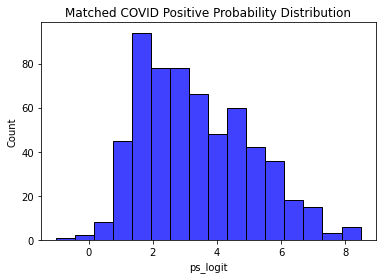

In [433]:
sns.histplot(data=matchedresult2, x='ps_logit', color="blue").set(title = "Matched COVID Positive Probability Distribution")

In [438]:
matched_covid_result = all_matched_result[all_matched_result['covid_status']==True]

In [440]:
noncovid_result = result[result['covid_status']==False]

In [442]:
noncovid_result['age'].mean()

73.435

In [439]:
matched_result['age'].mean()

73.34833333333333